In [17]:
import numpy as np
import sounddevice as sd
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# =========================================
# Parámetros generales
# =========================================
fs = 44100          # Frecuencia de muestreo
Tb = 0.01          # Duración de cada símbolo 8-FSK (s)
A = 0.5             # Amplitud de la señal
samples_per_sym = int(fs * Tb)

# 8 frecuencias para 8-FSK (todas < 12 kHz)
base_f = 3000       # Hz
spacing = 500       # Hz
freqs = base_f + spacing * np.arange(8)  # [3000, 3500, ..., 6500]

# Banda global para el filtro de recepción
low_global = base_f - 500
high_global = freqs[-1] + 500

# =========================================
# Preambulo (más largo)
# Debe tener longitud múltiplo de 3 bits (3 bits por símbolo)
# Aquí usamos 96 bits = 32 símbolos 8-FSK
# Patrón pseudo-aleatorio pero fijo:
PREAMBLE_BITS = ("101001111000" * 8)   # 12 bits * 8 = 96 bits

# =========================================
# Utilidades de texto <-> bits
# =========================================
def text_to_bits(texto: str) -> str:
    return ''.join(format(ord(c), '08b') for c in texto)

def bits_to_text(bits: str) -> str:
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) == 8:
            chars.append(chr(int(byte, 2)))
    return ''.join(chars)

# =========================================
# Conversión bits <-> símbolos 8-FSK
# Cada símbolo representa 3 bits (000..111)
# =========================================
def bits_to_symbols(bitstring: str):
    # Relleno a múltiplo de 3 bits
    if len(bitstring) % 3 != 0:
        bitstring = bitstring + '0' * (3 - (len(bitstring) % 3))
    symbols = []
    for i in range(0, len(bitstring), 3):
        symbols.append(int(bitstring[i:i+3], 2))
    return symbols, bitstring  # devuelvo también el bitstring (ya padded)

def symbol_to_bits(sym: int) -> str:
    # 0..7 -> '000'..'111'
    return format(sym, '03b')

# =========================================
# Filtros
# =========================================
def bandpass(lowcut, highcut, data):
    b, a = butter(4, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    return lfilter(b, a, data)

# =========================================
# Transmisor 8-FSK
# =========================================
def generate_symbol(sym_index: int) -> np.ndarray:
    """
    Genera la forma de onda de un símbolo 8-FSK (3 bits) usando la frecuencia correspondiente.
    """
    t = np.linspace(0, Tb, samples_per_sym, endpoint=False)
    freq = freqs[sym_index]
    return A * np.sin(2 * np.pi * freq * t)

# Construimos la forma de onda del preámbulo una vez
def build_preamble_waveform() -> np.ndarray:
    preamble_symbols, _ = bits_to_symbols(PREAMBLE_BITS)
    preamble_wave = np.concatenate([generate_symbol(s) for s in preamble_symbols])
    return preamble_wave

PREAMBLE_WAVEFORM = build_preamble_waveform()
PREAMBLE_SYMBOLS, PREAMBLE_BITS_PADDED = bits_to_symbols(PREAMBLE_BITS)
NUM_PREAMBLE_SYMBOLS = len(PREAMBLE_SYMBOLS)

def build_frame_8fsk(mensaje: str) -> np.ndarray:
    """
    Construye el audio 8-FSK completo con:
    - Silencio inicial
    - Preambulo (PREAMBLE_BITS)
    - Datos del mensaje (bits)
    - Silencio final
    Todo modulado en 8-FSK (3 bits por símbolo).
    """
    # Silencio inicial (0.5 s)
    silencio_ini = np.zeros(int(0.5 * fs))

    # Datos
    data_bits = text_to_bits(mensaje)

    # Puedes añadir un marcador final si quieres:
    # end_bits = "00000000"
    # frame_bits = PREAMBLE_BITS + data_bits + end_bits
    frame_bits = PREAMBLE_BITS + data_bits

    # Agrupar en símbolos 8-FSK (3 bits/símbolo)
    symbols, frame_bits_padded = bits_to_symbols(frame_bits)

    # Modulación 8-FSK: concatenar cada símbolo
    signal = np.concatenate([generate_symbol(s) for s in symbols])

    # Silencio final (0.5 s)
    silencio_fin = np.zeros(int(0.5 * fs))

    # Concatenar todo
    audio = np.concatenate([silencio_ini, signal, silencio_fin])

    return audio

def transmit_display_8fsk(mensaje: str):
    """
    Genera audio 8-FSK del mensaje y lo muestra como reproductor de audio (para notebook).
    """
    if not mensaje:
        print("Mensaje vacío, no se transmitirá nada.")
        return

    print(f"Mensaje a codificar en 8-FSK: {mensaje}")
    audio = build_frame_8fsk(mensaje)
    display(Audio(audio, rate=fs))
    return audio

# =========================================
# Receptor 8-FSK con correlación de preámbulo
# =========================================
def detect_symbol(segment: np.ndarray) -> str:
    """
    Dado un segmento de duración Tb, calcula la energía
    alrededor de cada una de las 8 frecuencias y devuelve
    los 3 bits del símbolo detectado (como string 'xyz').
    """
    energies = []
    bw = 250  # ancho de banda +- 250 Hz alrededor de cada tono
    for f in freqs:
        seg_f = bandpass(f - bw, f + bw, segment)
        energies.append(np.sum(seg_f**2))

    sym_index = int(np.argmax(energies))
    return symbol_to_bits(sym_index)

def receive_8fsk(duration=10):
    """
    Receptor 8-FSK:
    - Graba 'duration' segundos de audio
    - Aplica un paso banda amplio para limpiar
    - Usa correlación con la forma de onda del preámbulo para
      encontrar el instante de inicio del preámbulo
    - Alinea a múltiplos de símbolo
    - Desde el final del preámbulo comienza a decodificar símbolos
    - Reconstruye la cadena de bits y decodifica el texto.
    """
    print("Escuchando (8-FSK)...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()

    audio = audio.flatten()

    # Filtro paso banda global
    audio = bandpass(low_global, high_global, audio)

    # Visualizar señal recibida (opcional)
    plt.figure()
    plt.plot(audio)
    plt.title("Señal recibida (filtrada global)")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.show()

    # -----------------------------------------
    # Detección de preámbulo por correlación
    # -----------------------------------------
    p = PREAMBLE_WAVEFORM
    if len(audio) < len(p):
        print("Audio demasiado corto para contener el preámbulo.")
        return

    # correlación "valid": audio[i:i+len(p)] contra p
    corr = np.correlate(audio, p, mode='valid')
    peak_idx = int(np.argmax(corr))

    print(f"Índice de máxima correlación (muestras): {peak_idx}")

    # Alineamos al símbolo más cercano
    aligned_start = int(round(peak_idx / samples_per_sym)) * samples_per_sym
    print(f"Inicio alineado a símbolo (muestras): {aligned_start}")

    # Muestra de inicio de los datos (después del preámbulo)
    data_start_sample = aligned_start + NUM_PREAMBLE_SYMBOLS * samples_per_sym

    if data_start_sample >= len(audio):
        print("No hay datos después del preámbulo (audio muy corto).")
        return

    # -----------------------------------------
    # Decodificación símbolo por símbolo
    # -----------------------------------------
    bits = ""
    i = data_start_sample
    while i + samples_per_sym <= len(audio):
        segment = audio[i:i+samples_per_sym]
        bits += detect_symbol(segment)
        i += samples_per_sym

    print("Bits recibidos (primeros 96):", bits[:96], "...")
    print("Texto decodificado:")
    print(bits_to_text(bits))

# =========================================
# Ejemplo de uso del transmisor (en notebook)
# =========================================
if __name__ == "__main__":
    # Ejemplo de transmisión
    mensaje = (
        "1.Este es un mensaje de prueba para la transmisión 8-FSK con preámbulo largo. "
        "2.Este es otro bloque para verificar la modulación por desplazamiento de frecuencia con 8 tonos."
    )
    audio_fsk = transmit_display_8fsk(mensaje)

    # Para probar el receptor en tiempo real:
    # receive_8fsk(duration=15)


Mensaje a codificar en 8-FSK: 1.Este es un mensaje de prueba para la transmisión 8-FSK con preámbulo largo. 2.Este es otro bloque para verificar la modulación por desplazamiento de frecuencia con 8 tonos.


Escuchando (8-FSK)...


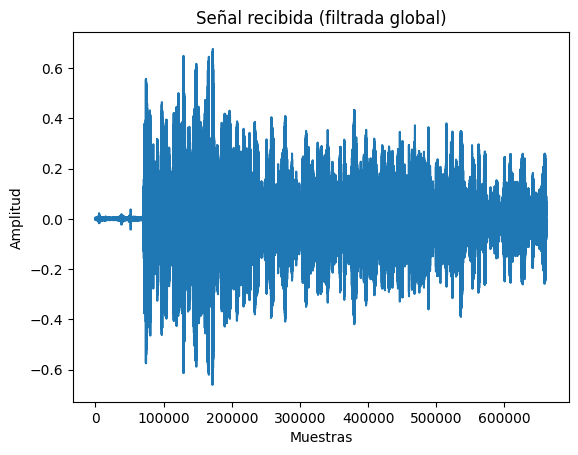

ATENCIÓN: no se encontró el preámbulo, decodificando todo lo recibido.
Bits recibidos (primeros 96): 000001110000000001001000000000010010000000001000000010001000001001110000000001001001001001001000 ...
Texto decodificado:
 HpHakd$e°û%a a²al!´avmioón 8.FS{ ~õ%#e³#´ lõ% q!a sk²kfi±#la mcõdccó~ ±#be


In [ ]:
receive_8fsk(duration=8)